In [0]:
### Prepare module structure ###

import sys

try:
    from google.colab import drive
    drive.mount('/content/drive/')
    ondrive = True
except:
    ondrive = False
    
if ondrive:
    %cd "/content/drive/My Drive/git/PhaseRetrieval/code/"
    #!pip install -q pytorch-lightning
else:
    %cd ".."

sys.path.append(".")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/git/PhaseRetrieval/code


In [0]:
### Import ###

import time

import numpy as np
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import figure
figure(figsize=(12, 4))

from util import *
import models
import data
#import trainers

# auto reload imports on local changes
%load_ext autoreload
%autoreload 2

<Figure size 864x288 with 0 Axes>

In [0]:
### CHECK DEVICE ###

USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


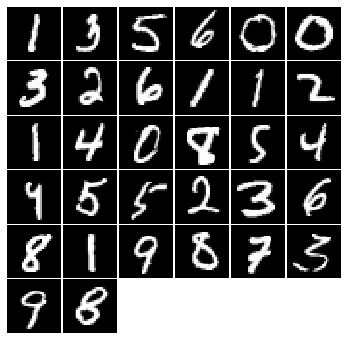

torch.Size([32, 1, 28, 28])


In [0]:
### LOAD DATA ###

dataloader, imsize = data.load('MNIST', batch_size=32)

sample = next(iter(dataloader['train']))
plot_grid2(sample)
print(sample.shape)
sample_ft =  torch.rfft(sample, 2, onesided=False)
sample_magnitudes = torch.sqrt(torch.sum(sample_ft**2, -1))

In [0]:
def calc_mags(x):
    ft =  torch.rfft(x, 2, onesided=False)
    mags = torch.sqrt(torch.sum(ft ** 2, -1) + 1e-16)
    return mags

def test_model(model, device, testloader):
    # put model to eval mode
    model.to(device)
    model.eval()
    
    # move test images to device and reduce to magnitude information in fourier space
    test_images = []
    kernel_outputs = []
    outputs = []
    
    for data in testloader:
        data = data.to(device=device)
        magn = calc_mags(data)
        
        out = model(magn)

        test_images.append(data.cpu().numpy())
        outputs.append(out.detach().cpu().numpy())
    
    return np.concatenate(outputs), np.concatenate(test_images)

In [0]:
### LOAD MODEL ###

net = models.FCNet(imsize=imsize, h=2048)
net.load_state_dict(torch.load("cache/FCNet2048MNIST_0020_20190805-151844.sd"));

Version 0.4


In [0]:
# Get test predictions #

test_predicted, test_original  = test_model(net, device, dataloader['test'])
print(test_predicted.shape)

(8000, 1, 28, 28)


In [8]:
# Benchmark test predictions #

benchmark(pred=test_predicted, true=test_original, check=["mse", "fasi", "coco", "magn", "imcon"])

Signal error:
  MSE: 0.0205815458746074, std: 0.016868655141858667
  FASI-MSE: 0.01656701742163568, std: 0.01058429247074586
  COCO-MSE: 0.015353633065786736, std: 0.008434438977647032

Magnitude error:
  MSE Magnitude: 4.349126507148056, std: 2.988886819335393

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]


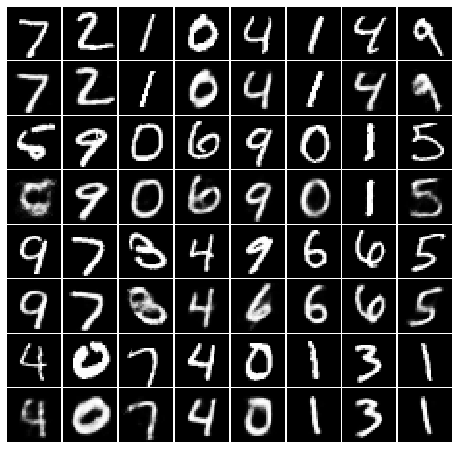

In [9]:
# Print test predictions #

plot_grid2(np.stack([ test_original[:32, 0].reshape(4, 8, 28, 28), test_predicted[:32, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 28, 28))

In [0]:
### Hand Paper (adapted) ###

# Optimise over input only
def genopt(sample_magnitudes, model, device, init_x='magn', max_steps=5000, max_loss=0.05):
    
    model.to(device)
    model.eval()
    
    if init_x == 'rnd':
        z = torch.randn((sample_magnitudes.shape), requires_grad=True, device=device)
    else:
        z = sample_magnitudes.clone().detach().to(device).requires_grad_(True)
  
    criterion = nn.MSELoss()
    optimizer = optim.Adam([z], lr=1.0)
    
    losses = []
    last_out = model(z)
    
    for i in range(max_steps):
 
        magnitudes = calc_mags(last_out)
        loss = criterion(magnitudes, sample_magnitudes)
        
        if loss < max_loss:
            break

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        last_out = model(z)

        losses.append(loss.item())
        
    return last_out.detach(), losses


import copy


# Optimise over network layers
def genopt2(sample_magnitudes, model, device, max_steps=5000, max_loss=0.05, lr=1e-4):
    
    total_losses = np.full((len(sample_magnitudes), max_steps + 1), np.NAN)
    total_out = []
    
    for i, magn in enumerate(sample_magnitudes):
        magn.unsqueeze_(0)
    
        cur_model = copy.deepcopy(model)
        cur_model.to(device)
        cur_model.eval()

        criterion = nn.MSELoss()
        optimizer = optim.Adam(cur_model.parameters(), lr=lr)

        last_out = cur_model(magn)
        magnitudes = calc_mags(last_out)
        loss = criterion(magnitudes, magn)
        
        losses = [loss]
        best_out = last_out
        best_loss = np.Inf

        for j in range(max_steps):

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            last_out = cur_model(magn)
            magnitudes = calc_mags(last_out)
            loss = criterion(magnitudes, magn)
            
            losses.append(loss.item())
            if loss < best_loss:
                best_loss = loss
                best_out = last_out.detach().cpu().numpy()
            if loss < max_loss:
                break
                
                
            
        total_losses[i, :(j+2)] = losses
        total_out.append(best_out)
        print("Iteration {} finished in {} steps".format(i + 1, j + 1))
        
    return np.vstack(total_out), total_losses

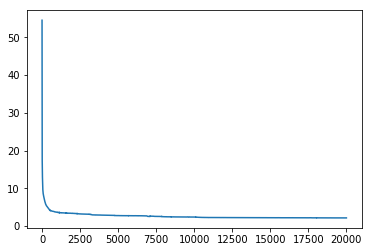

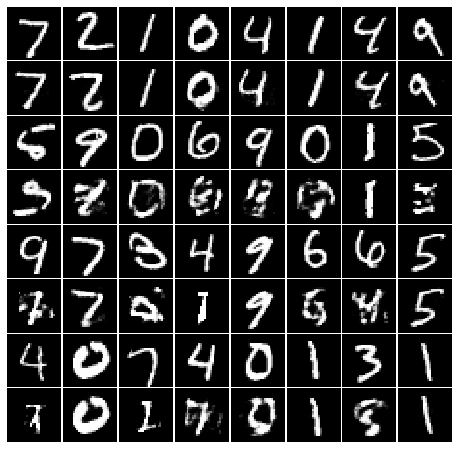

Signal error:
  MSE: 0.08345602
  FASI-MSE: 0.044516031842931625
  COCO-MSE: 0.03414529086764909

Magnitude error:
  MSE Magnitude: 2.171005032248978

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]


In [0]:
### Test one sample z opt ###

max_steps = 20000
max_loss = 0.0

test_sample = next(iter(dataloader['test'])).to(device)
test_magnitudes = calc_mags(test_sample)

out_results, losses = genopt(sample_magnitudes=test_magnitudes, model=net, device=device, init_x='rnd', max_steps=max_steps, max_loss=max_loss)
out_results = out_results.cpu().numpy()

plt.plot(losses)
plt.show()

plot_grid2(np.stack([test_sample.cpu()[:32, 0].reshape(4, 8, 28, 28), out_results[:32, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 28, 28),
           file='out/{0}.png'.format(time.strftime("%Y%m%d_%H%M%S")))

benchmark(pred=out_results, true=test_sample.cpu().numpy(), check=["mse", "fasi", "coco", "magn", "imcon"])

Version 0.4
Iteration 1 finished in 1000 steps
Iteration 2 finished in 1000 steps
Iteration 3 finished in 937 steps
Iteration 4 finished in 381 steps
Iteration 5 finished in 190 steps
Iteration 6 finished in 1000 steps
Iteration 7 finished in 355 steps
Iteration 8 finished in 589 steps
Iteration 9 finished in 272 steps
Iteration 10 finished in 429 steps
Iteration 11 finished in 1000 steps
Iteration 12 finished in 592 steps
Iteration 13 finished in 398 steps
Iteration 14 finished in 604 steps
Iteration 15 finished in 497 steps
Iteration 16 finished in 602 steps
Iteration 17 finished in 290 steps
Iteration 18 finished in 168 steps
Iteration 19 finished in 382 steps
Iteration 20 finished in 310 steps
Iteration 21 finished in 271 steps
Iteration 22 finished in 1000 steps
Iteration 23 finished in 382 steps
Iteration 24 finished in 313 steps
Iteration 25 finished in 377 steps
Iteration 26 finished in 438 steps
Iteration 27 finished in 275 steps
Iteration 28 finished in 255 steps
Iteration 29

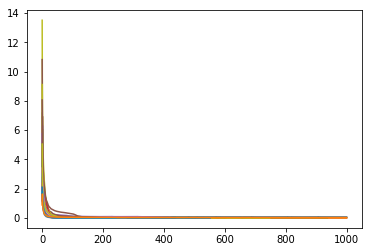

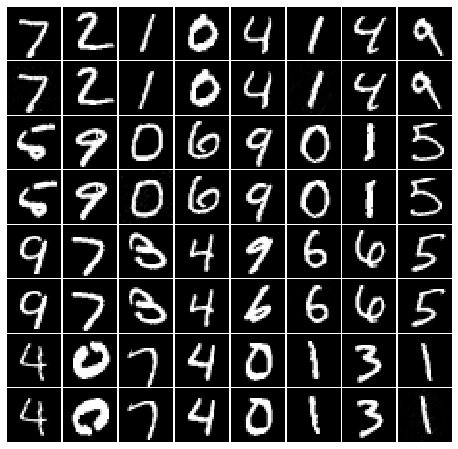

Signal error:
  MSE: 0.01972153718500813, std: 0.028023658011738006
  FASI-MSE: 0.0005774674182958961, std: 0.0018948012408643296
  COCO-MSE: 0.0005774667712610112, std: 0.001894802144212448

Magnitude error:
  MSE Magnitude: 0.004865866832493925, std: 0.013047064269912263

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]


In [11]:
### Test one sample net opt ###

newnet = models.FCNet(imsize=imsize, h=2048)
newnet.load_state_dict(torch.load("cache/FCNet2048MNIST_0020_20190805-151844.sd"));

max_steps = 1000
max_loss = 1e-4

test_sample = next(iter(dataloader['test'])).to(device)
test_magnitudes = calc_mags(test_sample)

out_results, losses = genopt2(sample_magnitudes=test_magnitudes, model=newnet, device=device, max_steps=max_steps, max_loss=max_loss, lr=1e-3)

plt.plot(losses.T)
plt.show()

plot_grid2(np.stack([test_sample.cpu()[:32, 0].reshape(4, 8, 28, 28), out_results[:32, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 28, 28),
           file='out/{0}.png'.format(time.strftime("%Y%m%d_%H%M%S")))
benchmark(pred=out_results, true=test_sample.cpu().numpy(), check=["mse", "fasi", "coco", "magn", "imcon"])

In [0]:
np.min(losses, axis=1)

array([0.02746076, 0.00029345,        nan,        nan,        nan,
       0.02791055,        nan,        nan,        nan,        nan,
       0.05901603,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan, 0.00431541,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan, 0.03420435])

z Optimization

| Init | steps | Magn Err | MSE | FASI | COCO | 
| --- | --- | --- | --- | --- | --- |
| magn | 20000 | 0.2678| 0.0157 | 0.00241 | 0.00241 | 
| rnd | 20000 | 2.171 | 0.0834 | 0.0445 | 0.0341


model Optimization

| Params | max steps | max loss | lr | Magn Err | MSE | FASI | COCO | 
| --- | --- | --- | --- | --- | --- |  --- |  --- |
| all | 100 | 0.01 | 1e-3 | 0.0245 | 0.0193 | 0.000993 | 0.000993 | 
| all | 1000 | 0.0 | 1e-3 | 0.00583 | 0.0197 | 0.000578 | 0.000578
| all | 1000 | 0.0 | 1e-4 | 0.00543 | 0.0196 | 0.000681| 0.000544 
| all | 1000 | 1e-4 | 1e-4 | 0.00546 | 0.0196 | 0.000681 | 0.000545
| all | 1000 (take best step) | 1e-4 | 1e-4 | 0.00544 | 0.0196 | 0.000681 |  0.000545
| all | 5000 (take best step) | 1e-4 | 1e-4 | 0.00525 | 0.0195 | 0.000648 | 0.000553
| all | 1000 (take best step) | 1e-4 | 1e-3 | 0.00486 |0.0197 | 0.000577 |  0.000577
